## <span style="color:green"><h1><center>DEM Processing</center></h1></span>
<center>Prepared by <br>
    <b>Jibin Joseph and Venkatesh Merwade</b><br> 
Lyles School of Civil Engineering, Purdue University<br>
joseph57@purdue.edu, vmerwade@purdue.edu<br>
<b><br>
    FAIR Science in Water Resources</b><br></center>


## <span style="color:green">Objective</span>
<p style='text-align: justify;'> The objective of this tutorial is to learn how to merge, project, and clip the DEM raster files. We will use the downloaded DEM raster files from USGS National Elevation Dataset from previous DEM Downloading module.</p> 

## <span style="color:green"> Data Source </span>

<p style='text-align: justify;'>USGS 1/3 arc second DEM</p>

## <span style="color:green">Overview of steps </span>
<ol type="1">
    <span style="color:red"><li>Read and plot original files</li></span>
    <span style="color:red"><li>Merge or Mosaick the the original files (not needed if only one raster sile is downloaded)</li></span>
     <span style="color:red"><li>Reproject or Transform coordinate system fro Goegraphic to Projected Coordinate System</li></span>
    <span style="color:red"><li>Clipping or Masking the reprojected raster file</li></span>



## <span style="color:green">Import the packages/modules required for this exercise</span>

We need different packages as shown below. It can be either installed using pip method or conda method.


In [1]:
# %pip install airavata-jupyter-magic
import airavata_jupyter_magic

%authenticate
%request_runtime test_cpu --cluster=Anvil --cpus=4 --memory=4096 --walltime=10 --queue=shared --group=CyberFaCES
%switch_runtime test_cpu


Loaded airavata_jupyter_magic
(current runtime = local)

  %authenticate                      -- Authenticate to access high-performance runtimes.
  %request_runtime <rt> [args]       -- Request a runtime named <rt> with configuration <args>. Call multiple times to request multiple runtimes.
  %stop_runtime <rt>                 -- Stop runtime <rt> when no longer needed.
  %switch_runtime <rt>               -- Switch active runtime to <rt>. All subsequent executions will use this runtime.
  %%run_on <rt>                      -- Force a cell to always execute on <rt>, regardless of the active runtime.
  %copy_data <r1:file1> <r2:file2>   -- Copy <file1> in <r1> to <file2> in <r2>.


User code: IZXC-STVJ
Please authenticate by visiting: https://auth.cybershuttle.org/realms/default/device?user_code=IZXC-STVJ
Authorization pending, retrying...
Authorization pending, retrying...
Received access token
Requested runtime=test_cpu. state=14
Switched to runtime=test_cpu.


In [1]:
## Import the modules/packages/libraries required
import math
import matplotlib.pyplot as plt
import os

from pynhd import NLDI
import rasterio
import rasterio.plot

import geopandas # for reading the shapefile

## Merging/ Mosaicking
from rasterio.merge import merge

## Reprojecting
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pyproj

## Clipping
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
from shapely.geometry import Polygon


Waiting for runtime=test_cpu to be ready...
Runtime=test_cpu is ready!


In [1]:
print(rasterio.__version__)
print(geopandas.__version__)
print(pyproj.__version__)

Runtime=test_cpu is ready!
1.4.3
1.0.1
3.7.1


## <span style="color:green">Step 1: Define the variables and plot unmerged raster files</span> 
<ul>
<li>Variables: <span style="color:red">USGS Site, resolution, directories, extents</span></li>
<li>Plot Unmerged files: <span style="color:red">using rasterio plot</span></li>

Runtime=test_cpu is ready!
The required lon and lat pairs are: 
 [(85, 41), (86, 41), (86, 42), (87, 41), (87, 42), (88, 41)]

Number of tiles required to cover the entire region: 8
Left: 88, Right: 85, Bottom: 41, Top: 42

Number of tiles within watershed boundary: 6


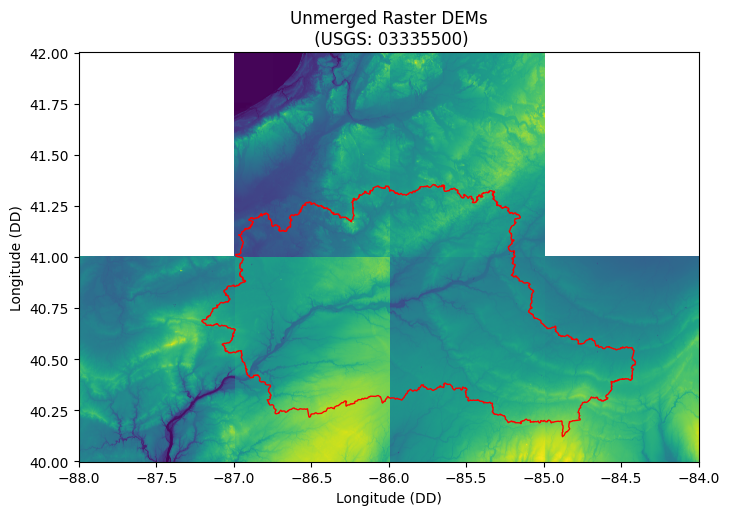

In [1]:
## Few variables from previous DEM Access Modules
#site_id ='04180000' #two raster files to cover the entire watershed
#site_id='03343000' # WABASH RIVER AT VINCENNES, IN - 13907 sq mi
#site_id='03335500'

# site_id='14183000'
site_id='03335500'
resolution='1'
folder_input=f'./input_{site_id}'
# dem_files_store=f'{folder_input}/raw_{site_id}'
dem_files_store= folder_input
##Read the shapefile using geopandas
watershed =geopandas.read_file(f'{folder_input}/shape_{site_id}.shp')
## Get the extents and number of tiles downloaded
extents_basin=watershed.total_bounds
extent_left=abs(math.floor(extents_basin[0]))
extent_right=abs(math.floor(extents_basin[2]))
extent_bottom=abs(math.ceil(extents_basin[1]))
extent_top=abs(math.ceil(extents_basin[3]))
num_tiles_download=(((extent_left+1)-extent_right)*((extent_top+1)-extent_bottom))
## Define a empty list to hold lon and lat pair
overlap_lonlat=[]

## Create a for loop to create a rectangular boundary and see if overlaps with watershed
for lon in (range(extent_right,extent_left+1,1)):
    for lat in (range(extent_bottom,extent_top+1,1)):
        ## Defining in anticlockwise direction
        corner_left_bottom=(-lon,lat-1)
        corner_right_bottom=(-lon+1,lat-1)
        corner_right_top=(-lon+1,lat)
        corner_left_top=(-lon,lat)
        
        # Create a polygon from the coordinates
        rectangular_boundary = Polygon([corner_left_bottom,corner_right_bottom,corner_right_top,corner_left_top])

        # Create a GeoDataFrame
        rectangular_gdf = gpd.GeoDataFrame(geometry=[rectangular_boundary])
        
        # Set the coordinate reference system (CRS) if needed
        # Example: gdf.crs = {'init': 'epsg:4326'}  # WGS84

        rectangular_gdf.crs = watershed.crs

        # Perform the overlay operation to find the intersection
        intersection = gpd.overlay(watershed, rectangular_gdf, how='intersection')

        # Check if there's any intersection
        if not intersection.empty:
            #print("The rectangular polygon overlaps with the shapefile.")
            overlap_lonlat.append((lon,lat))
        #else:
        #    print("The rectangular polygon does not overlap with the shapefile.")       

print("The required lon and lat pairs are: \n",overlap_lonlat)

## Calulate the number of tiles to be downloaded from USGS
num_tiles_download=(((extent_left+1)-extent_right)*((extent_top+1)-extent_bottom))
print(f"\nNumber of tiles required to cover the entire region: {num_tiles_download}")
print(f"Left: {extent_left}, Right: {extent_right}, Bottom: {extent_bottom}, Top: {extent_top}")

print(f"\nNumber of tiles within watershed boundary: {len(overlap_lonlat)}")

if (len(overlap_lonlat)>1):
    title=f"Unmerged Raster DEMs\n (USGS: {site_id})"
else:
    title=f"Single Raster DEM\n (USGS: {site_id})"



## Plotting

fig, ax = plt.subplots(figsize=(8, 8))
for location in overlap_lonlat:
        usgs_filename=f'n{location[1]:02d}w{location[0]:03d}'
        ## WRITE THE CODE BELOW
        local_raster_filename=fr'{dem_files_store}/USGS_{resolution}_{usgs_filename}.tif'
        raster = rasterio.open(local_raster_filename)
        rasterio.plot.show(raster,
                           ax=ax,
                           cmap='viridis')
        #print(f'lat: {lat},lon: {lon},file:{local_fileloc_filename}')
watershed.plot(ax=ax, 
           facecolor='none', 
           edgecolor='red')
plt.title(title)
plt.xlabel("Longitude (DD)")
plt.ylabel("Longitude (DD)")


## Free up memory
del raster
del fig,ax

## <span style="color:green">Step 2: Merging the raster</span> 

<ul>
<li>Input: <span style="color:red">Downloaded raster tiles</span></li>
<li>Output: <span style="color:red">Merged raster tile</span></li>

## <span style="color:green">Step 2a: Create folder for saving the intermediate files</span>
    

In [1]:
def check_create_path_func(path):
    isExist = os.path.exists(path)
    if not isExist:
        # Create a new directory because it does not exist
        os.makedirs(path)
        print(f"The new directory \033[1m'{path}'\033[0m is created!")
    else:
        print(f"The new directory \033[1m'{path}'\033[0m is not created as it already exists!")      
## Create the a folder for intermediate raster files 
folder_intermediate=f'{folder_input}/intermediate_{site_id}'
check_create_path_func(folder_intermediate)
folder_results=f'{folder_input}/results_{site_id}'
check_create_path_func(folder_results)

Runtime=test_cpu is ready!
The new directory './input_03335500/intermediate_03335500' is created!
The new directory './input_03335500/results_03335500' is created!


## <span style="color:green">Step 2b: Merging the rasters (if required)</span>

<ul>
<li> Define a function for merging the raster files </li>
<li> Create a filename for saving the merged raster files </li>
<li> Call the defined function merging the rasters</li>

In [1]:
def merge_dem_raster_func(input_foldername, output_filename):
    ## Get a list of all DEM files in the input folder
    dem_files = [f for f in os.listdir(input_foldername) if f.startswith(f"USGS_{resolution}_")]
    ## Create a list to store the raster datasets
    datasets = []
    ## Open each DEM file and append it to the datasets list
    for dem_file in dem_files:
        file_path = os.path.join(input_foldername, dem_file)
        src = rasterio.open(file_path)
        datasets.append(src)
    ## Merge the raster datasets into a single mosaic and return ndarray and information on mapping the pixel coordinates
    mosaic_new_raster, mosaic_transform = merge(datasets,
                                                resampling=Resampling.nearest,
                                                method='first',
                                                target_aligned_pixels=False
                                               )
    ## Copy the metadata from one of the datasets (assuming they all have the same metadata)
    out_meta = datasets[0].meta.copy()
    
    #print("Before",out_meta)
    out_meta.update({
        'height': mosaic_new_raster.shape[1],
        'width': mosaic_new_raster.shape[2],
        'transform': mosaic_transform ## copy the transform parameter from merge
    })
    #print("After",out_meta)
    
    #print("Dataset-0",datasets[0].meta.copy())
    #print("Dataset-1",datasets[1].meta.copy())
    #print("Dataset-2",datasets[2].meta.copy())
    #print("Dataset-3",datasets[3].meta.copy())
    #print("Dataset-4",datasets[4].meta.copy())
    #print("Dataset-5",datasets[5].meta.copy())
    
    # Write the mosaic to the output file
    with rasterio.open(output_filename, 'w', **out_meta) as dest:
        dest.write(mosaic_new_raster)
    ## Close all the opened datasets
    for dataset in datasets:
        dataset.close()
    print(f"Merging completed for {len(overlap_lonlat)} DEM raster files")
    del mosaic_new_raster




## WRITE THE CODE BELOW 
if num_tiles_download==1:
    merged_raster_filename=f'{dem_files_store}/USGS_{resolution}_{usgs_filename}.tif'
    print("No need to merge as only one tiff file")
    title_4_plot=f"Original DEM Raster (Merging not required) in {watershed.crs} Geographic CRS\n(for USGS {site_id})"
else:
    merged_raster_filename=f'{folder_intermediate}/merged_{resolution}_{site_id}.tif'
    merge_dem_raster_func(dem_files_store, merged_raster_filename)
    title_4_plot=f"Merged DEM Raster in {watershed.crs} Geographic CRS\n(for USGS {site_id})"

Runtime=test_cpu is ready!
Merging completed for 6 DEM raster files


In [1]:
"""dem_files = [f for f in os.listdir(dem_files_store) if f.startswith(f"USGS_{resolution}_")]
#print(dem_files)
## Create a list to store the raster datasets
datasets = []
## Open each DEM file and append it to the datasets list
for dem_file in dem_files:
    file_path = os.path.join(dem_files_store, dem_file)
    src = rasterio.open(file_path)
    datasets.append(src)
#print(datasets)
## Merge the raster datasets into a single mosaic
mosaic, out_trans = merge(datasets)
print(type(mosaic))
print(out_trans)
print(type(out_trans))"""

Runtime=test_cpu is ready!
'dem_files = [f for f in os.listdir(dem_files_store) if f.startswith(f"USGS_{resolution}_")]\n#print(dem_files)\n## Create a list to store the raster datasets\ndatasets = []\n## Open each DEM file and append it to the datasets list\nfor dem_file in dem_files:\n    file_path = os.path.join(dem_files_store, dem_file)\n    src = rasterio.open(file_path)\n    datasets.append(src)\n#print(datasets)\n## Merge the raster datasets into a single mosaic\nmosaic, out_trans = merge(datasets)\nprint(type(mosaic))\nprint(out_trans)\nprint(type(out_trans))'


In [ ]:
with rasterio.open(merged_raster_filename) as src:
    print(src)
    fig, ax = plt.subplots(figsize = (8,8))
    mapped=rasterio.plot.show(src,
                              ax=ax, 
                              cmap='viridis')
    im = mapped.get_images()[0]
    fig.colorbar(im,
                 ax=ax,
                 shrink=0.5,
                 label='Elevation (in meters)',
                 location='right',
                 orientation='vertical')
    ax.set_xlabel("Longitude (DD)")
    ax.set_ylabel("Latitude (DD)")
    ax.set_title(title_4_plot)
    
watershed.plot(ax=ax, 
           facecolor='none', 
           edgecolor='red')
src.close()
del mapped,im
del fig,ax

Runtime=test_cpu is ready!


## <span style="color:green">Step 3: Reproject both shapefile and the raster to PCS from GCS</span>

<ul>
<li> Find the UTM Zone for Projected Coordinate System using the centroid point </li>
<li> Project the merged dem </li>

In [ ]:
## Find if basin has a projection
print(watershed.crs)

## <span style="color:green">Step 3a: Finding the UTM Zone</span>

<ul>
<li> Find the approximate centroid </li>    
<li> Find whether the centroid is in N or S </li>
<li> Calculate the zone value (below calculations applciable to conterminous US) </li>


In [ ]:
## Find the approximate centroid
df=watershed
df['geometry'].centroid
## Find the center point
df['Center_point'] = df['geometry'].centroid
## Extract lat and lon from the centerpoint
df["lon"] = df.Center_point.map(lambda p: p.x)
df["lat"] = df.Center_point.map(lambda p: p.y)
df

In [ ]:
## Calculate N or S
if 0 < df['lat'][0] < 84:
    lat_zone='N'
elif -84 < df['lat'][0] < 0:
    lat_zone='S'

## Calculate zone 
## Applicable for US only

if -138 < df['lon'][0] < -132:
    zone_value='08'
elif -132 < df['lon'][0] < -126:
    zone_value='09'
elif -126 < df['lon'][0] < -120:
    zone_value='10'
elif -120 < df['lon'][0] < -114:
    zone_value='11'
elif -114 < df['lon'][0] < -108:
    zone_value='12'
elif -108 < df['lon'][0] < -102:
    zone_value='13'
elif -102 < df['lon'][0] < -96:
    zone_value='14'
elif -96 < df['lon'][0] < -90:
    zone_value='15'
elif -90 < df['lon'][0] < -84:
    zone_value='16'
elif -84 < df['lon'][0] < -78:
    zone_value='17'
elif -78 < df['lon'][0] < -72:
    zone_value='18'
elif -72 and df['lon'][0] < -66:
    zone_value='19'
elif -66 < df['lon'][0] < -60:
    zone_value='20'    
elif -60 < df['lon'][0] < -54:
    zone_value='21'
elif -54 < df['lon'][0] < -48:
    zone_value='22'      
else:
    print("not in conterminous US")
    
crs_string=f'EPSG:326{zone_value}'
crs_string

In [ ]:
## Alternative Method to estimate the CRS
crs_string2=watershed.estimate_utm_crs(datum_name='WGS 84')
crs_string2

## <span style="color:green">Step 3b: Reprojecting watershed shapefile to UTM using calculated zone</span>

<ul>
<li> Using the string created for EPSG (by calculated zone value), reproject it to PCS  </li>
<li> Calculate the zone value (below calculations applciable to conterminous US) </li>

In [ ]:
folder_results=f'{folder_input}/results_{site_id}'
#folder_results=f'C:/temp/JibinJoseph/GDAL_operations/results_{site_id}'
check_create_path_func(folder_results)

shapefile_fileloc_filename=f'{folder_input}/shape_{site_id}.shp'
watershed_file=geopandas.read_file(shapefile_fileloc_filename)
watershed_proj=watershed_file.to_crs(crs_string)

In [ ]:
print(watershed_file.crs)
print(watershed_proj.crs)
print(type(watershed_file))
print(type(watershed_proj))

In [ ]:
proj_shapefile_filename=f'{folder_results}/proj_shp_{site_id}.shp'
print(proj_shapefile_filename)
watershed_proj.to_file(proj_shapefile_filename, driver='ESRI Shapefile',mode='w')

## <span style="color:green">Step 3c: Reprojecting merged raster to UTM using calculated zone</span>

<ul>
<li> Using the string created for EPSG (by calculated zone value), reproject it to PCS  </li>
<li> Calculate the zone value (below calculations applciable to conterminous US) </li>

In [ ]:
def reproject_raster_func(input_raster, output_raster, target_crs):
    # Load the input DEM
    with rasterio.open(input_raster) as src:
        # Define the target CRS
        target_crs_proj = pyproj.CRS.from_string(target_crs)
        # Calculate the transformation and new dimensions
        transform, width, height = calculate_default_transform(src.crs, target_crs_proj, src.width, src.height, *src.bounds)
        # Update metadata for the new dataset
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs_proj,
            'transform': transform,
            'width': width,
            'height': height
        })
        # Create the output dataset and perform the reprojection
        print(src)
        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                print(rasterio.band(src, i))
                reproject(
                    source=rasterio.band(src, i),
                    #source=src.read,
                    destination=rasterio.band(dst, i),
                    #destination=dst,
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs_proj,
                    resampling=Resampling.nearest)
        print("Reprojection complete.")
## WRITE CODE BELOW

reprojected_raster_filename=f'{folder_intermediate}/reprojected_{resolution}_{site_id}.tif'
print(merged_raster_filename,"\n",reprojected_raster_filename)
reproject_raster_func(merged_raster_filename, reprojected_raster_filename, crs_string)

In [ ]:
reprojected_raster_filename=f'{folder_intermediate}/reprojected_{resolution}_{site_id}.tif'
with rasterio.open(reprojected_raster_filename) as src:
    fig, ax = plt.subplots(figsize = (8,8))
    mapped=rasterio.plot.show(src,
                              ax=ax, 
                              cmap='viridis')
    im = mapped.get_images()[0]
    fig.colorbar(im,
                 ax=ax,
                 shrink=0.5,
                 label='Elevation (in meters)',
                 location='right',
                 orientation='vertical')
    ax.set_xlabel("Easting (meters)")
    ax.set_ylabel("Northing (meters)")
    ax.set_title(f"Reprojected Raster DEM in {watershed_proj.crs} Projected CRS\n(for USGS {site_id})")

## Uee the reprojected watershed shapefile
watershed_proj.plot(ax=ax, 
           facecolor='none', 
           edgecolor='red')
src.close()

del mapped,im
del fig,ax

## <span style="color:green">Step 4: Clipping the reprojected raster file using watershed shapefile</span>

<ul>
<li> Using the string created for EPSG (by calculated zone value), reproject it to PCS  </li>
<li> Calculate the zone value (below calculations applciable to conterminous US) </li>

In [ ]:
proj_shapefile_filename=f'{folder_results}/proj_shp_{site_id}.shp'

def clip_raster_with_shapefile_func(input_raster, output_raster, shapefile,buffer_value):
    ## Open the shapefile using geopandas
    shapefile_gdf = geopandas.read_file(shapefile).buffer(buffer_value)
    ## Open the input raster
    with rasterio.open(input_raster) as src:
        ## Convert the shapefile geometry to the same CRS as the raster
        shapefile_gdf = shapefile_gdf.to_crs(src.crs)
        ## Convert the shapefile geometry to GeoJSON-like format
        geoms = [mapping(geom) for geom in shapefile_gdf.geometry]
        ## Clip the raster using the shapefile geometry
        clipped, out_transform = mask(src, geoms, crop=True)
        ## Update metadata for the new dataset
        out_meta = src.meta.copy()
        out_meta.update({
            'height': clipped.shape[1],
            'width': clipped.shape[2],
            'transform': out_transform
        })
        ## Write the clipped raster to the output file
        with rasterio.open(output_raster, 'w', **out_meta) as dst:
            dst.write(clipped)
    print("Raster clipping complete.")
## WRITE THE CODE BELOW    

buffer_value_in_meters=1500

clipped_raster_filename=f'{folder_results}/clipped_{resolution}_{site_id}.tif'
clip_raster_with_shapefile_func(reprojected_raster_filename,
                                clipped_raster_filename,
                                proj_shapefile_filename,
                                buffer_value_in_meters)

In [ ]:
with rasterio.open(clipped_raster_filename) as src1:
    fig, ax = plt.subplots(figsize = (8,8))
    mapped=rasterio.plot.show(src1,
                              ax=ax, 
                              cmap='viridis')
    im = mapped.get_images()[0]
    fig.colorbar(im,
                 ax=ax,
                 shrink=0.5,
                 label='Elevation (in meters)',
                 location='right',
                 orientation='vertical')
    ax.set_xlabel("Easting (meters)")
    ax.set_ylabel("Northing (meters)")
    ax.set_title(f"Clipped Raster DEM with a buffer of {buffer_value_in_meters} m and {watershed_proj.crs} Projected CRS\n(for USGS {site_id})")

## Uee the reprojected watershed shapefile
watershed_proj.plot(ax=ax, 
           facecolor='none', 
           edgecolor='red')
src.close()